# Nested Logit Model

In this notebook, we delve into the analysis of transportation mode choices using a nested logit model, focusing on a dataset derived from a survey conducted among Swiss residents. Our journey begins with importing and preparing the dataset, followed by defining utility functions that capture the essence of how individuals perceive the value of different transportation modes—public transport, car, and soft modes like walking or cycling. We then introduce the concept of nested logit models, which allow us to account for similarities within groups of choices, enhancing our model's realism and accuracy.

As we progress, we estimate the model's parameters to uncover the factors that significantly influence transportation choices, such as cost, travel time, and distance, and observe how these factors vary by employment status and gender. We further evaluate the model's performance through various statistical metrics, ensuring its reliability and validity.

By the end of this notebook, you will have gained insights into the complexities of transportation mode choice behavior and the practical application of nested logit models in analyzing discrete choice data. This knowledge can be useful for academic research but also can provide perspectives for policymakers and urban planners aiming to design more efficient and sustainable transportation systems.

In [1]:
import pandas as pd
import numpy as np
import biogeme.database as db
import biogeme.biogeme as bio
import biogeme.models as models
import biogeme.optimization as opt
from biogeme.expressions import Beta, DefineVariable
import seaborn as sns
import matplotlib.pyplot as plt

**Import Optima data**

In [2]:
pandas = pd.read_csv("../../Data/8-DiscreteChoiceModels/optima.dat",sep='\t')
database = db.Database ("data/optima", pandas)

**Use collumn names as variables**

In [3]:
globals().update(database.variables)

## Let's see what this dataset has

* Estimation of a mode choice behavior model for inhabitants in Switzerland using revealed preference data
* Objective was to show the market potential for combined mobility, especially within agglomerations, taking into account the factors that influence travellers in their choice of transport
* The survey was conducted between 2009 and 2010 for CarPostal, the public transport branch of the Swiss Postal Service
* 1124 completed surveys were collected. For each respondent, cyclic sequences of trips (starting and ending at the same location) are detected and their main transport mode is identified. The resulting data base includes 1906 sequences of trips linked with psychometric indicators and socio-economic attributes of the respondents.

![](img/optima_var1.png)

![](img/optima_var2.png)

**Exclude some unwanted entries**

In [4]:
exclude = (Choice == -1.)
database.remove(exclude)

**Define some dummy variables**

In [5]:
male = (Gender == 1)
female = (Gender == 2)
unreportedGender = (Gender == -1)

fulltime = (OccupStat == 1)
notfulltime = (OccupStat != 1)

**Rescale some data**

In [6]:
TimePT_scaled = TimePT / 200
TimeCar_scaled = TimeCar / 200
MarginalCostPT_scaled = MarginalCostPT / 10 
CostCarCHF_scaled = CostCarCHF / 10
distance_km_scaled = distance_km / 5

And many more variables...

In [7]:
pandas = database.data

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

pandas.describe()

ID      DestAct     NbTransf       TimePT  WalkingTimePT  WaitingTimePT       CostPT      CostCar      TimeCar  NbHousehold      NbChild        NbCar       NbMoto       NbBicy  NbBicyChild       NbComp         NbTV     Internet  NewsPaperSubs  NbCellPhones  NbSmartPhone    HouseType     OwnHouse  NbRoomsHouse  YearsInHouse       Income       Gender    BirthYear  Mothertongue    FamilSitu    OccupStat  SocioProfCat  CalculatedIncome    Education   HalfFareST    LineRelST      GenAbST    AreaRelST      OtherST     CarAvail  MarginalCostPT   CostCarCHF      Envir01      Envir02      Envir03      Envir04      Envir05      Envir06      Mobil01      Mobil02      Mobil03      Mobil04      Mobil05      Mobil06      Mobil07      Mobil08      Mobil09      Mobil10      Mobil11      Mobil12      Mobil13      Mobil14      Mobil15      Mobil16      Mobil17      Mobil18      Mobil19      Mobil20      Mobil21      Mobil22      Mobil23      Mobil24      Mobil25      Mobil26  \
count  1.906000e+03  1906.000000  1906.000000  1906.000000    1906.000000    1906.000000  1906.000000  1906.000000  1906.000000  1906.000000  1906.000000  1906.000000  1906.000000  1906.000000  1906.000000  1906.000000  1906.000000  1906.000000    1906.000000   1906.000000   1906.000000  1906.000000  1906.000000   1906.000000   1906.000000  1906.000000  1906.000000  1906.000000   1906.000000  1906.000000  1906.000000   1906.000000       1906.000000  1906.000000  1906.000000  1906.000000  1906.000000  1906.000000  1906.000000  1906.000000     1906.000000  1906.000000  1906.000000  1906.000000  1906.000000  1906.000000  1906.000000  1906.000000  1906.000000  1906.000000  1906.000000  1906.000000  1906.000000  1906.000000  1906.000000  1906.000000  1906.000000  1906.000000  1906.000000  1906.000000  1906.000000  1906.000000  1906.000000  1906.000000  1906.000000  1906.000000  1906.000000  1906.000000  1906.000000  1906.000000  1906.000000  1906.000000  1906.000000  1906.000000   
mean   4.587880e+07     4.218783     2.007870   107.882476      39.625393      13.125393    18.853122     4.018431    40.675236     2.609129     0.455929     1.363589     0.182057     2.483736     0.435992     1.657398     1.196222     0.977440       1.119622      2.087618      0.206716     1.172088     1.168940      4.681532     13.892445     3.701469     1.360441  1842.123295      1.188877     2.620672     3.146905      4.157922       7880.547744     3.941763     1.518363     1.940189     1.911333     1.927597     1.955929     1.101259       11.105404     5.758499     2.524659     3.141133     2.733998     2.443861     3.416055     4.059286     3.908709     2.995803     3.241343     4.081322     3.251836     3.493704     3.792760     2.261805     3.694648     3.785939     3.550367     1.922350     4.107555     3.047219     3.727702     3.271249     3.440714     2.813746     3.639035     3.431794     3.243442     2.535152     4.019937     3.262854     2.139559     3.087618   
std    2.384691e+07     3.535628     2.170535    86.520629      27.999199      22.073856    23.666168     5.817255    47.612389     1.481257     1.068960     0.890024     0.746585     1.954334     1.163011     1.331090     0.969512     0.507182       0.628595      1.461019      0.806325     0.674062     0.648682      1.985008     12.845272     1.957707     0.721393   467.378286      0.764022     1.634398     3.224485      2.627481       4078.861884     2.030804     0.499794     0.237199     0.284338     0.259222     0.205308     0.761080       16.130519     8.336017     1.632244     1.515109     1.530810     1.373635     1.470456     1.383119     1.662954     1.857377     1.682858     1.539403     1.676629     1.635310     1.449254     1.430885     1.503152     2.145943     1.522821     1.451311     1.501172     1.536562     1.481589     1.498339     1.667632     1.564179     1.572342     1.856765     1.614085     1.490855     1.590200     1.665350     1.682218     1.840685   
min    1.035002e+07    -1.000000     0.000000    

C:\code\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


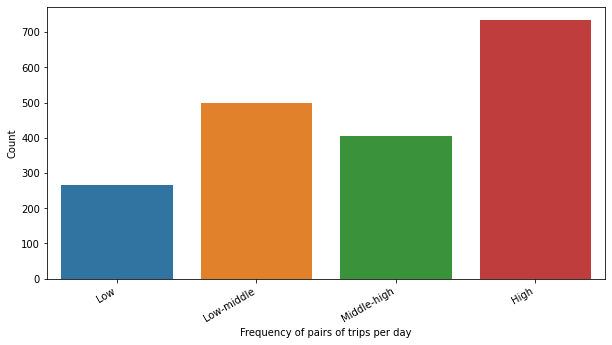

In [8]:
plt.figure(figsize=(10,5))
chart = sns.countplot(pandas['frequency'])
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');
chart.set_xticklabels(['Low', 'Low-middle', 'Middle-high', 'High']);
chart.set(xlabel="Frequency of pairs of trips per day", ylabel = "Count");

C:\code\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


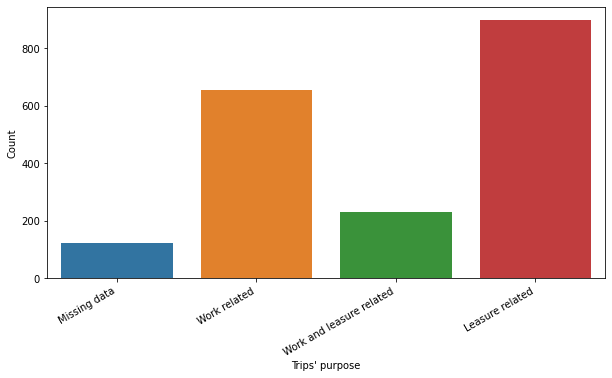

In [9]:
plt.figure(figsize=(10,5))
chart = sns.countplot(pandas['TripPurpose'])
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');
chart.set_xticklabels(['Missing data',
                            'Work related', 
                            'Work and leasure related',
                            'Leasure related']);
chart.set(xlabel="Trips' purpose", ylabel = "Count");

C:\code\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


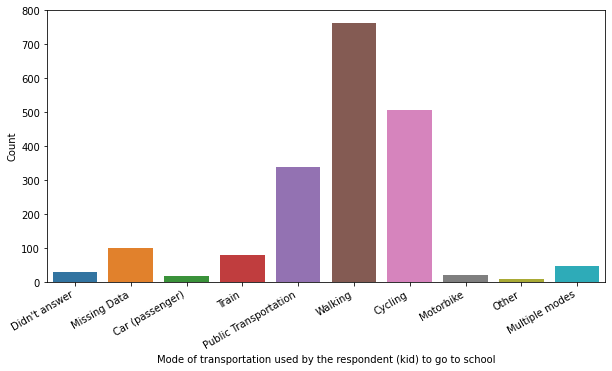

In [10]:
plt.figure(figsize=(10,5))
chart = sns.countplot(pandas['ModeToSchool'])
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');
chart.set_xticklabels(['Didn\'t answer', 'Missing Data', 'Car (passenger)', 'Train', 'Public Transportation',  'Walking', 'Cycling', 'Motorbike', 'Other', 'Multiple modes']);
chart.set(xlabel="Mode of transportation used by the respondent (kid) to go to school", ylabel = "Count");

### Defining and fitting a nested logit model


**Define the utility functions**

Utility functions represent the perceived value or utility of choosing a particular alternative by an individual. In the given code, three utility functions are defined for public transport (`V_PT`), car (`V_CAR`), and soft modes (`V_SM`), each as a linear combination of parameters (`Beta`) and variables.

For example, `V_PT` includes terms for the full-time status of the individual, scaled travel time, and cost. The coefficients (betas) represent the impact of each variable on the utility. The inclusion of different terms for full-time and other employment statuses allows for differentiation in value perception based on employment. Similarly, gender-specific terms in `V_SM` allow for gender-specific preferences in mode choice.


\begin{align}
V_{PT} & = \beta_{PT} + \beta_{time_{fulltime}} X_{time_{PT}} X_{fulltime} + \beta_{time_{other}} X_{time_{PT}} X_{not\_fulltime} + \beta_{cost} X_{cost_{PT}} \\
V_{car} & = \beta_{car} + \beta_{time_{fulltime}} X_{time_{car}} X_{fulltime} + \beta_{time_{other}} X_{time_{car}} X_{not\_fulltime} + \beta_{cost} X_{cost_{car}} \\
V_{SM} & = \beta_{SM} + \beta_{male} X_{distance} X_{male} + \beta_{female} X_{distance} X_{female} + \beta_{unreported} X_{distance} X_{unreported}
\end{align}

**Create parameters to be estimated**

Parameters to be estimated (`Beta` objects) represent the coefficients in the utility functions. These coefficients quantify the impact of various factors (e.g., travel time, cost) on the choice of a transport mode. The code initializes these parameters with starting values and specifies whether they are fixed or to be estimated. `ASC_*` parameters are alternative specific constants, providing the baseline utility of each choice, while other parameters like `BETA_TIME_FULLTIME` and `BETA_COST` represent sensitivities to travel time and cost, respectively.

Each `Beta` object includes 5 parameters: name, initial value, lower bound, upper bound, fixed.

In [11]:
ASC_CAR              = Beta('ASC_CAR',0,None,None,0)
ASC_PT               = Beta('ASC_PT',0,None,None,1)
ASC_SM               = Beta('ASC_SM',0,None,None,0)
BETA_TIME_FULLTIME   = Beta('BETA_TIME_FULLTIME',0,None,None,0)
BETA_TIME_OTHER      = Beta('BETA_TIME_OTHER',0,None,None,0)
BETA_DIST_MALE       = Beta('BETA_DIST_MALE',0,None,None,0)
BETA_DIST_FEMALE     = Beta('BETA_DIST_FEMALE',0,None,None,0)
BETA_DIST_UNREPORTED = Beta('BETA_DIST_UNREPORTED',0,None,None,0)
BETA_COST            = Beta('BETA_COST',0,None,None,0)

**Define the utility functions in Python**

In [12]:
V_PT = ASC_PT + BETA_TIME_FULLTIME * TimePT_scaled * fulltime + \
       BETA_TIME_OTHER * TimePT_scaled * notfulltime + \
       BETA_COST * MarginalCostPT_scaled
V_CAR = ASC_CAR + \
        BETA_TIME_FULLTIME * TimeCar_scaled * fulltime + \
        BETA_TIME_OTHER * TimeCar_scaled * notfulltime + \
        BETA_COST * CostCarCHF_scaled
V_SM = ASC_SM + \
       BETA_DIST_MALE * distance_km_scaled * male + \
       BETA_DIST_FEMALE * distance_km_scaled * female + \
       BETA_DIST_UNREPORTED * distance_km_scaled * unreportedGender

**Associate utility functions with alternatives and associate availability of alternatives**

This step maps each utility function to its corresponding transportation alternative and specifies the availability of each alternative. In the provided context, all alternatives are assumed to be available to everyone, which is represented by setting the availability (`av`) of all alternatives to 1.

In [13]:
# Map utility functions to transportation alternatives
V = {0: V_PT,
     1: V_CAR,
     2: V_SM}

# Specifies the availability of each alternative
av = {0: 1,
      1: 1,
      2: 1}

**Define the nests**

Nesting allows for the modeling of correlation in the unobserved factors affecting the choices within the same nest. It acknowledges that choices within a nest (e.g., `NO_CAR_NEST`) are more similar to each other than to choices outside the nest.

The `MU_NO_CAR` parameter is a measure of this correlation within the `NO_CAR_NEST`. Higher values indicate greater similarity within the nest. The nests are defined with a structure indicating which alternatives belong to which nest, allowing the model to account for similarities and differences in choice correlations across nests.

In [14]:
# Define the scale parameter for the no-car nest, indicating the degree of correlation between alternatives within the nest.
MU_NO_CAR = Beta('MU_NO_CAR', 1.,1.,None,0)

# Define nests: CAR_NEST with no intra-nest correlation and NO_CAR_NEST with correlation parameter MU_NO_CAR.
CAR_NEST = 1., [1]
NO_CAR_NEST = MU_NO_CAR, [0, 2]

# Combine the defined nests into a tuple
nests = CAR_NEST, NO_CAR_NEST

**Define the model**

The nested logit model is defined using the utility functions, availability of alternatives, and nest definitions. The `models.lognested` function constructs the model's mathematical formulation, incorporating the logit model's properties and the nested structure. 

A nested logit model helps capturing both the choice process across alternatives and the correlation of choices within nests, providing a more accurate and nuanced understanding of decision-making compared to simple logit models.

In [15]:
logprob = models.lognested (V, av , nests , Choice )

**Define the Biogeme object**

A Biogeme object is instantiated with the database and the model. This object encapsulates the data and the nested logit model, preparing it for estimation.

In [16]:
biogeme = bio.BIOGEME(database, logprob)
biogeme.modelName = "optima_nested_logit"

**Estimate the model**

The model estimation involves optimizing the parameters to best fit the observed choices. Biogeme performs this optimization based on the defined model and the data, outputting estimated parameters, and optionally, bootstrap estimates for robustness checks.

In [17]:
biogeme.generateHtml = True
biogeme.generatePickle = True

results = biogeme.estimate(bootstrap=100)

print(f"HTML file:    {results.data.htmlFileName}")
print(f"Pickle file:  {results.data.pickleFileName }")

HTML file:    optima_nested_logit.html
Pickle file:  optima_nested_logit.pickle


**Print results**

Display the estimated parameters, which quantify the influence of each factor included in the utility functions.

In [18]:
print("Estimated betas: {}".format(len(results.data.betaValues)))

betas = results.getBetaValues()
for k,v in betas.items():
    print("{}= {}".format(k.ljust(25),v))

Estimated betas: 9
ASC_CAR                  = 0.26147366856401844
ASC_SM                   = 0.05916112728375036
BETA_COST                = -0.7161889749188455
BETA_DIST_FEMALE         = -0.8310907964443561
BETA_DIST_MALE           = -0.6862284337817491
BETA_DIST_UNREPORTED     = -0.7029816707208786
BETA_TIME_FULLTIME       = -1.5962723241026053
BETA_TIME_OTHER          = -0.576830892041444
MU_NO_CAR                = 1.5287463169080127


The results from the nested logit model estimation provide both the estimated parameters (betas).

- **ASC_CAR (0.2615)** and **ASC_SM (0.0592)** are the alternative-specific constants for the car and soft modes (e.g., walking, cycling), respectively. The positive values suggest a base preference for these modes over public transport, with a stronger preference for cars.
- **BETA_COST (-0.7162)** indicates the sensitivity of the choice to the cost associated with the travel mode. The negative sign signifies that as the cost increases, the utility of choosing a mode decreases, which is consistent with economic theory.
- **BETA_DIST_FEMALE (-0.8311)**, **BETA_DIST_MALE (-0.6862)**, and **BETA_DIST_UNREPORTED (-0.7030)** represent the negative impact of distance on the utility of soft modes for females, males, and those with unreported gender, respectively. The more negative value for females suggests a higher sensitivity to distance compared to males.
- **BETA_TIME_FULLTIME (-1.5963)** and **BETA_TIME_OTHER (-0.5768)** show the negative impact of travel time on the utility, with full-time workers being more sensitive to time than others. This indicates a higher value of time for full-time employees.
- **MU_NO_CAR (1.5287)** is the nest parameter for the "no car" nest, indicating the degree of correlation between the choices within this nest. Values greater than 1 suggest a positive correlation between the alternatives in the nest, implying that if a person is inclined to choose one alternative in the nest, they are more likely to consider other alternatives in the same nest as well.

**General Statistics**

General statistics offer a broad overview of the model's performance, including the log likelihood values, the Akaike Information Criterion (AIC), and the Bayesian Information Criterion (BIC), among others.

In [19]:
gs = results.getGeneralStatistics()

for k,v in gs.items():
    print("{}= {}".format(k.ljust(45),v[0]))

Number of estimated parameters               = 9
Sample size                                  = 1906
Excluded observations                        = 359
Init log likelihood                          = -2093.9550222014136
Final log likelihood                         = -1298.4982835573562
Likelihood ratio test for the init. model    = 1590.9134772881148
Rho-square for the init. model               = 0.3798824378795773
Rho-square-bar for the init. model           = 0.37558435129004863
Akaike Information Criterion                 = 2614.9965671147124
Bayesian Information Criterion               = 2664.97142587264
Final gradient norm                          = 0.011044410781700216
Bootstrapping time                           = 0:00:51.884767
Nbr of threads                               = 8


The general statistics evaluate the model's fit and performance. Notably:

- The **number of estimated parameters** is 9, matching the number of betas reported.
- The **sample size** is 1,906, with 359 observations excluded, likely due to incomplete or invalid responses.
- The **initial log likelihood** of -2094.0 and **final log likelihood** of -1298.5 show a significant improvement, indicating that the model fits the data well.
- The **likelihood ratio test** value of 1590.9 suggests that the model is significantly better than a null model with no predictors.
- **Rho-square values** are approximately 0.38 (initial) and 0.375 (rho-square-bar). Unlike R² in linear regression, these values do not represent the proportion of variation explained by the model. Instead, they compare the fit of the model to a base model, such as a null model. Higher values indicate better fit relative to the base model.
- The **Akaike Information Criterion (AIC)** and **Bayesian Information Criterion (BIC)** are 2615.0 and 2665.0, respectively. These metrics help in model comparison, with lower values indicating a better fit considering the number of parameters.
- The **final gradient norm** of 0.011 suggests that the optimization algorithm converged well, indicating a stable solution.
- The **bootstrapping time** and **number of threads** used provide information on the computational effort and resources utilized for estimation.

In summary, the model suggests that cost, travel time, and distance significantly influence transportation mode choice, with notable differences based on gender and employment status. The model fits the data well, as evidenced by the improvement in log likelihood and the likelihood ratio test.

### Summary
This notebook demonstrated how to estimate a nested logit model using Biogeme, focusing on the choice of transportation mode among Swiss residents. Key takeaways include the importance of specifying utility functions that accurately reflect the factors influencing individuals' choices, such as cost, travel time, and distance, with distinctions based on gender and employment status. The model's parameters revealed significant insights, such as the higher sensitivity to travel time among full-time workers and the greater distance sensitivity for females choosing soft modes of transport.

The estimation process highlighted the utility of nested logit models in capturing correlations within choice sets, allowing for more nuanced understanding of choice behaviors compared to simple logit models. General statistics provided evidence of the model's good fit and effectiveness in explaining transportation mode choices, underlined by significant improvements in log likelihood and appropriate rho-square values.